In [85]:
import geopandas as gpd
import matplotlib.pyplot as plt
import random
import math
import geojson
from shapely.geometry import Point


In [86]:
def generate_random_polygon(num_points, num_angles):
    # Calculate the angle step based on the number of angles
    angle_step = 360.0 / num_angles

    # Generate random radii for each point
    radii = [random.uniform(0.1, 1.0) for _ in range(num_points)]

    # Calculate the coordinates of the points on the border
    coordinates = []
    for i in range(num_points):
        angle = i * angle_step
        x = radii[i] * math.cos(math.radians(angle))
        y = radii[i] * math.sin(math.radians(angle))
        coordinates.append((x, y))

    # Close the polygon by adding the first point at the end
    coordinates.append(coordinates[0])

    # Create a GeoJSON Feature
    feature = geojson.Feature(
        geometry=geojson.Polygon([coordinates]),
        properties={}
    )

    return feature

In [87]:
def generate_polygon(num_vertices):
    # Start with a simple polygon (e.g., a square)
    polygon = [(0, 0), (1, 0), (1, 1), (0, 1)]
    
    # Keep track of the edges
    edges = [(polygon[i], polygon[(i+1) % len(polygon)]) for i in range(len(polygon))]
    
    while len(polygon) < num_vertices:
        # Choose a random edge
        edge_index = random.randint(0, len(edges) - 1)
        edge = edges[edge_index]
        
        # Generate a random position along the edge
        x = random.uniform(edge[0][0], edge[1][0])
        y = random.uniform(edge[0][1], edge[1][1])
        new_vertex = (x, y)
        
        # Check for self-intersections
        valid = True
        for i in range(len(polygon)):
            if do_edges_intersect(new_vertex, polygon[i], polygon[(i+1) % len(polygon)]):
                valid = False
                break
        
        if valid:
            # Add the new vertex to the polygon
            polygon.insert(edge_index + 1, new_vertex)
            edges.insert(edge_index, (edge[0], new_vertex))
            edges[edge_index + 1] = (new_vertex, edge[1])
    
    return polygon

def do_edges_intersect(p1, q1, p2, q2):
    def ccw(a, b, c):
        return (c[1]-a[1]) * (b[0]-a[0]) > (b[1]-a[1]) * (c[0]-a[0])

    return ccw(p1, p2, q2) != ccw(q1, p2, q2) and ccw(p1, q1, p2) != ccw(p1, q1, q2)

if __name__ == "__main__":
    num_points = 8  # Number of points on the border
    num_angles = 6  # Number of polygon angles
    output_filename = "random_polygon.geojson"

    random_polygon = generate_random_polygon(num_points, num_angles)

    with open(output_filename, "w") as output_file:
        geojson.dump(random_polygon, output_file)

    print(f"Random polygon saved to {output_filename}")


Random polygon saved to random_polygon.geojson


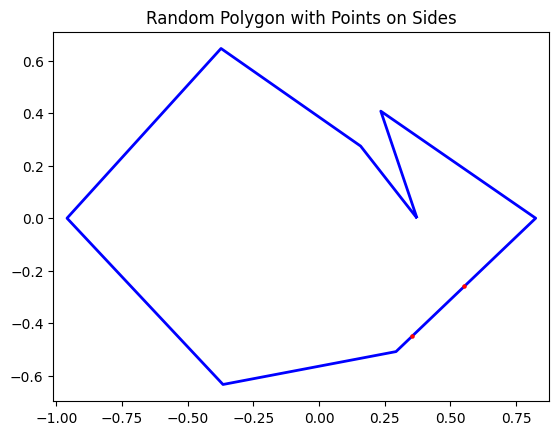

In [88]:
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
import matplotlib.pyplot as plt
import random

def distribute_points_on_random_edges(polygon, num_points):
    if num_points == 0:
        return []

    boundary = polygon.exterior
    edges = [LineString([boundary.coords[i], boundary.coords[i + 1]]) for i in range(len(boundary.coords) - 1)]
    
    points = []
    for _ in range(num_points):
        random_edge = random.choice(edges)
        edge_length = random_edge.length
        random_distance = random.uniform(0, edge_length)
        point = random_edge.interpolate(random_distance)
        points.append(point)

    return points

# Load the GeoJSON file
file_path = "random_polygon.geojson"
gdf = gpd.read_file(file_path)

# Extract the polygon
polygon = gdf['geometry'].iloc[0]

# Define the number of points along the sides
num_points_on_sides = 2  # Adjust this number as needed

# Distribute points on random edges of the polygon
side_points = distribute_points_on_random_edges(polygon, num_points_on_sides)

# Create a GeoSeries for the side points
side_series = gpd.GeoSeries(side_points, crs=gdf.crs)

# Create a GeoDataFrame for the side points
side_gdf = gpd.GeoDataFrame(geometry=side_series)

# Plot the polygon and side points
fig, ax = plt.subplots()
gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
side_gdf.plot(ax=ax, marker='o', color='red', markersize=5)
plt.title('Random Polygon with Points on Sides')
plt.axis('equal')  # Set equal aspect ratio
plt.show()


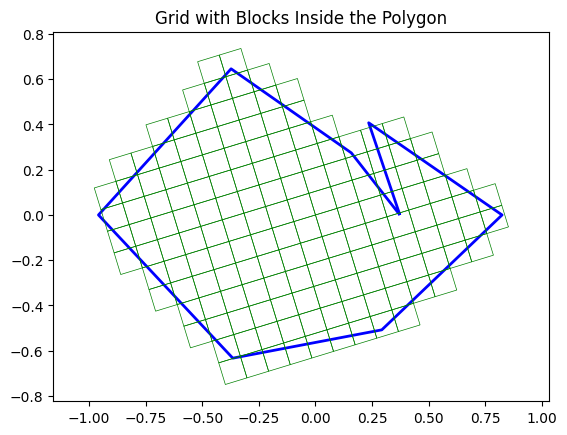

In [89]:
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString, box
import matplotlib.pyplot as plt
import numpy as np

# Load the GeoJSON file
file_path = "random_polygon.geojson"
gdf = gpd.read_file(file_path)

# Extract the polygon
polygon = gdf['geometry'].iloc[0]

# Define the angle (e.g., 17 degrees)
angle_degrees = 17

# Define the block size
block_size = 0.1  # Adjust this as needed

# Define the offset for the grid
offset_x, offset_y = 0, 0  # Adjust this as needed

# Function to rotate a point by a given angle around the origin
def rotate_point(point, angle):
    x, y = point
    angle_rad = np.radians(angle)
    x_rot = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_rot = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return (x_rot, y_rot)

# Create a rotated square grid
grid = []
for x in np.arange(-10, 10, block_size):
    for y in np.arange(-10, 10, block_size):
        square = box(x, y, x + block_size, y + block_size)
        rotated_square = Polygon([rotate_point(coord, angle_degrees) for coord in square.exterior.coords])
        
        # Check if any corner of the square is inside the polygon
        if any(polygon.contains(Point(coord)) for coord in rotated_square.exterior.coords):
            grid.append(rotated_square)

# Convert the grid to a GeoDataFrame
grid_gdf = gpd.GeoDataFrame(geometry=grid, crs=gdf.crs)

# Plot the polygon and the grid
fig, ax = plt.subplots()
gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
grid_gdf.boundary.plot(ax=ax, color='green', linewidth=0.5)
plt.title('Grid with Blocks Inside the Polygon')
plt.axis('equal')  # Set equal aspect ratio
plt.show()


93
94


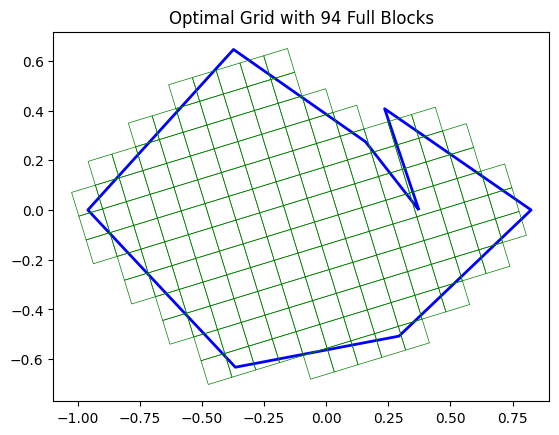

In [90]:
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString, box
import numpy as np
import matplotlib.pyplot as plt

def find_optimal_grid(polygon, block_size, max_offset, angle_step=1, angles = None):
    max_full_blocks = 0
    optimal_grid = None

    if angles is None:
        angle_vars = range(0, 360, angle_step)
    else:
        angle_vars = angles
    for angle in angle_vars:
        for offset_x in np.arange(-max_offset, max_offset + block_size, block_size):
            for offset_y in np.arange(-max_offset, max_offset + block_size, block_size):
                # Create a rotated square grid with the current angle and offset
                grid = []
                for x in np.arange(polygon.bounds[0] + offset_x, polygon.bounds[2] + offset_x, block_size):
                    for y in np.arange(polygon.bounds[1] + offset_y, polygon.bounds[3] + offset_y, block_size):
                        square = box(x, y, x + block_size, y + block_size)
                        rotated_square = Polygon([rotate_point(coord, angle) for coord in square.exterior.coords])
                        
                        # Check if any corner of the square is inside the polygon
                        if any(polygon.contains(Point(coord)) for coord in rotated_square.exterior.coords):
                            grid.append(rotated_square)

                # Calculate the number of full blocks within the polygon
                num_full_blocks = sum(polygon.contains(square) for square in grid)
                # Update the optimal configuration if needed
                if num_full_blocks > max_full_blocks:
                    print(num_full_blocks)
                    max_full_blocks = num_full_blocks
                    optimal_grid = grid

    return optimal_grid, max_full_blocks

# Load the GeoJSON file
file_path = "random_polygon.geojson"
gdf = gpd.read_file(file_path)

# Extract the polygon
polygon = gdf['geometry'].iloc[0]

# Define the block size
block_size = 0.1  # Adjust this as needed

# Define the maximum offset (not more than block_size)
max_offset = block_size

# Function to rotate a point by a given angle around the origin
def rotate_point(point, angle):
    x, y = point
    angle_rad = np.radians(angle)
    x_rot = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_rot = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return (x_rot, y_rot)


angles = [17, 19]
# Find the optimal grid configuration
optimal_grid, max_full_blocks = find_optimal_grid(polygon, block_size, max_offset, angles=angles)

# Create a GeoDataFrame for the optimal grid
optimal_grid_geoms = gpd.GeoSeries(optimal_grid, crs=gdf.crs)
optimal_grid_gdf = gpd.GeoDataFrame(geometry=optimal_grid_geoms, crs=gdf.crs)

# Plot the polygon and the optimal grid
fig, ax = plt.subplots()
gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
optimal_grid_gdf.boundary.plot(ax=ax, color='green', linewidth=0.5)
plt.title(f'Optimal Grid with {max_full_blocks} Full Blocks')
plt.axis('equal')  # Set equal aspect ratio automatically
plt.show()



In [91]:
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString, box
import numpy as np
import matplotlib.pyplot as plt

def distribute_points_on_random_edges(polygon, num_points):
    if num_points == 0:
        return []

    boundary = polygon.exterior
    edges = [LineString([boundary.coords[i], boundary.coords[i + 1]]) for i in range(len(boundary.coords) - 1)]
    
    points = []
    for _ in range(num_points):
        random_edge = random.choice(edges)
        edge_length = random_edge.length
        random_distance = random.uniform(0, edge_length)
        point = random_edge.interpolate(random_distance)
        points.append(point)

    return points

def find_optimal_grid_with_entry_points(polygon, block_size, max_offset, num_points_on_sides, angle_step=1, angles = None):
    max_full_blocks = 0
    optimal_grid = None

    if angles is None:
        angle_vars = range(0, 360, angle_step)
    else:
        angle_vars = angles
    for angle in angle_vars:
        for offset_x in np.arange(-max_offset, max_offset + block_size, block_size):
            for offset_y in np.arange(-max_offset, max_offset + block_size, block_size):
                # Create a rotated square grid with the current angle and offset
                grid = []
                for x in np.arange(polygon.bounds[0] + offset_x, polygon.bounds[2] + offset_x, block_size):
                    for y in np.arange(polygon.bounds[1] + offset_y, polygon.bounds[3] + offset_y, block_size):
                        square = box(x, y, x + block_size, y + block_size)
                        rotated_square = Polygon([rotate_point(coord, angle) for coord in square.exterior.coords])
                        
                        # Check if any corner of the square is inside the polygon
                        if any(polygon.contains(Point(coord)) for coord in rotated_square.exterior.coords):
                            grid.append(rotated_square)

                # Calculate the number of full blocks within the polygon
                num_full_blocks = sum(polygon.contains(square) for square in grid)

                # Update the optimal configuration if needed
                if num_full_blocks > max_full_blocks:
                    max_full_blocks = num_full_blocks
                    optimal_grid = grid

    return optimal_grid, max_full_blocks

# Load the GeoJSON file
file_path = "random_polygon.geojson"
gdf = gpd.read_file(file_path)

# Extract the polygon
polygon = gdf['geometry'].iloc[0]

# Define the block size
block_size = 0.1  # Adjust this as needed

# Define the maximum offset (not more than block_size)
max_offset = block_size

# Define the number of points on the sides
num_points_on_sides = 4  # Adjust this as needed

# Function to rotate a point by a given angle around the origin
def rotate_point(point, angle):
    x, y = point
    angle_rad = np.radians(angle)
    x_rot = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_rot = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return (x_rot, y_rot)

# Find the optimal grid configuration
angles = [17, 19]
optimal_grid, max_full_blocks = find_optimal_grid_with_entry_points(
    polygon, block_size, max_offset, num_points_on_sides, angles=angles)

# Create a GeoDataFrame for the optimal grid
optimal_grid_geoms = gpd.GeoSeries(optimal_grid, crs=gdf.crs)
optimal_grid_gdf = gpd.GeoDataFrame(geometry=optimal_grid_geoms, crs=gdf.crs)

# Calculate entry points
entry_points = distribute_points_along_edges(polygon, num_points_on_sides)
entry_points_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(entry_points), crs=gdf.crs)

# Plot the polygon, entry points, and the optimal grid
fig, ax = plt.subplots()
gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
entry_points_gdf.plot(ax=ax, marker='o', color='red', markersize=5)
optimal_grid_gdf.boundary.plot(ax=ax, color='green', linewidth=0.5)
plt.title(f'Optimal Grid with {max_full_blocks} Full Blocks and Entry Points')
plt.axis('equal')  # Set equal aspect ratio automatically
plt.show()


NameError: name 'distribute_points_along_edges' is not defined

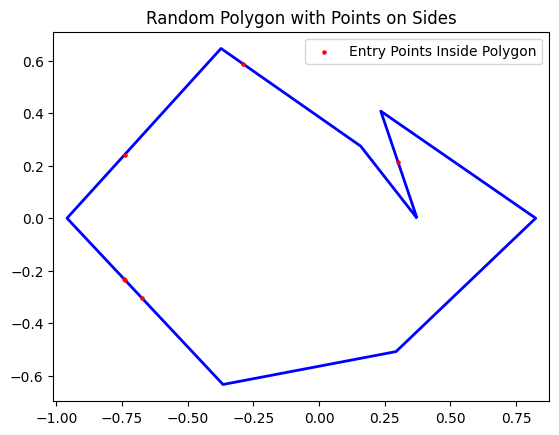

In [92]:
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
import matplotlib.pyplot as plt
import random
import json

def distribute_points_on_random_edges(polygon, num_points):
    if num_points == 0:
        return []

    boundary = polygon.exterior
    edges = [LineString([boundary.coords[i], boundary.coords[i + 1]]) for i in range(len(boundary.coords) - 1)]
    
    points = []
    for _ in range(num_points):
        random_edge = random.choice(edges)
        edge_length = random_edge.length
        random_distance = random.uniform(0, edge_length)
        point = random_edge.interpolate(random_distance)
        points.append(point)

    return points

# Load the GeoJSON file
file_path = "random_polygon.geojson"
gdf = gpd.read_file(file_path)

# Extract the polygon
polygon = gdf['geometry'].iloc[0]

# Define the number of points along the sides
num_points_on_sides = 10  # Adjust this number as needed

# # Distribute points on random edges of the polygon
side_points = distribute_points_on_random_edges(polygon, num_points_on_sides)

# # Create a GeoSeries for the side points
# side_series = gpd.GeoSeries(side_points, crs=gdf.crs)

# # Create a GeoDataFrame for the side points
# side_gdf = gpd.GeoDataFrame(geometry=side_series)

# Filter and save entry points within the polygon
entry_points_inside_polygon = [point for point in side_points if polygon.contains(point)]
entry_points_inside_polygon_gdf = gpd.GeoSeries(entry_points_inside_polygon, crs=gdf.crs)
entry_points_inside_polygon_gdf.to_file("entry_points_inside_polygon.geojson", driver='GeoJSON')

# Plot the polygon, side points, and entry points within the polygon
fig, ax = plt.subplots()
gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
# side_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Side Points')
entry_points_inside_polygon_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Entry Points Inside Polygon')
plt.title('Random Polygon with Points on Sides')
plt.legend()
plt.axis('equal')  # Set equal aspect ratio
plt.show()


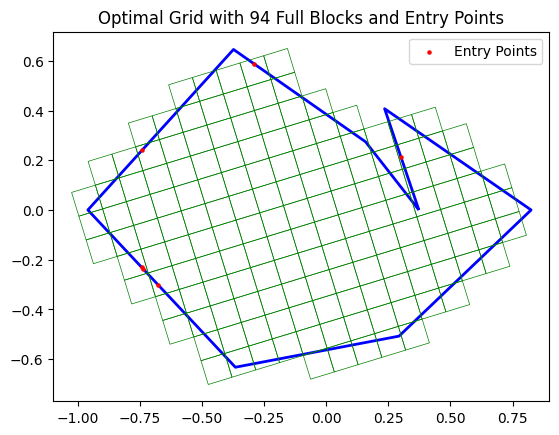

In [93]:
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString, box
import numpy as np
import matplotlib.pyplot as plt

def distribute_points_on_random_edges(polygon, num_points):
    if num_points == 0:
        return []

    boundary = polygon.exterior
    edges = [LineString([boundary.coords[i], boundary.coords[i + 1]]) for i in range(len(boundary.coords) - 1)]
    
    points = []
    for _ in range(num_points):
        random_edge = random.choice(edges)
        edge_length = random_edge.length
        random_distance = random.uniform(0, edge_length)
        point = random_edge.interpolate(random_distance)
        points.append(point)

    return points

def find_optimal_grid_with_entry_points(polygon, block_size, max_offset, num_points_on_sides, angle_step=1, angles=None):
    max_full_blocks = 0
    optimal_grid = None

    if angles is None:
        angle_vars = range(0, 360, angle_step)
    else:
        angle_vars = angles
    for angle in angle_vars:
        for offset_x in np.arange(-max_offset, max_offset + block_size, block_size):
            for offset_y in np.arange(-max_offset, max_offset + block_size, block_size):
                # Create a rotated square grid with the current angle and offset
                grid = []
                for x in np.arange(polygon.bounds[0] + offset_x, polygon.bounds[2] + offset_x, block_size):
                    for y in np.arange(polygon.bounds[1] + offset_y, polygon.bounds[3] + offset_y, block_size):
                        square = box(x, y, x + block_size, y + block_size)
                        rotated_square = Polygon([rotate_point(coord, angle) for coord in square.exterior.coords])
                        
                        # Check if any corner of the square is inside the polygon
                        if any(polygon.contains(Point(coord)) for coord in rotated_square.exterior.coords):
                            grid.append(rotated_square)

                # Calculate the number of full blocks within the polygon
                num_full_blocks = sum(polygon.contains(square) for square in grid)

                # Update the optimal configuration if needed
                if num_full_blocks > max_full_blocks:
                    max_full_blocks = num_full_blocks
                    optimal_grid = grid

    return optimal_grid, max_full_blocks

# Load the GeoJSON file
file_path = "random_polygon.geojson"
gdf = gpd.read_file(file_path)

# Extract the polygon
polygon = gdf['geometry'].iloc[0]

# Define the block size
block_size = 0.1  # Adjust this as needed

# Define the maximum offset (not more than block_size)
max_offset = block_size

# Define the number of points on the sides
num_points_on_sides = 4  # Adjust this as needed

# Function to rotate a point by a given angle around the origin
def rotate_point(point, angle):
    x, y = point
    angle_rad = np.radians(angle)
    x_rot = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_rot = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return (x_rot, y_rot)

# Find the optimal grid configuration
angles = [17, 19]
optimal_grid, max_full_blocks = find_optimal_grid_with_entry_points(
    polygon, block_size, max_offset, num_points_on_sides, angles=angles)

# Create a GeoDataFrame for the optimal grid
optimal_grid_geoms = gpd.GeoSeries(optimal_grid, crs=gdf.crs)
optimal_grid_gdf = gpd.GeoDataFrame(geometry=optimal_grid_geoms, crs=gdf.crs)

# Load entry points from a GeoJSON file
entry_points_gdf = gpd.read_file("entry_points_inside_polygon.geojson")

# Plot the polygon, entry points, and the optimal grid
fig, ax = plt.subplots()
gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
entry_points_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Entry Points')
optimal_grid_gdf.boundary.plot(ax=ax, color='green', linewidth=0.5)
plt.title(f'Optimal Grid with {max_full_blocks} Full Blocks and Entry Points')
plt.legend()
plt.axis('equal')  # Set equal aspect ratio automatically
plt.show()


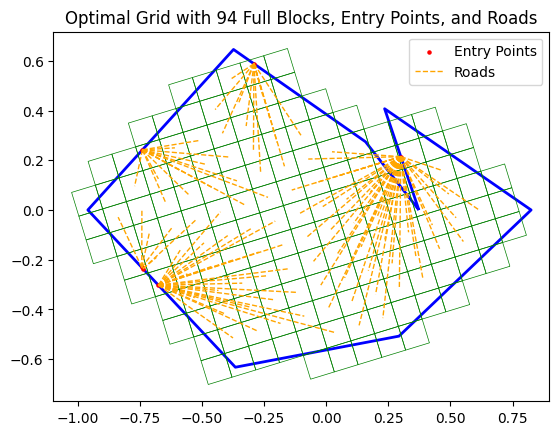

In [94]:
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
import matplotlib.pyplot as plt
import random

def distribute_points_on_random_edges(polygon, num_points):
    if num_points == 0:
        return []

    boundary = polygon.exterior
    edges = [LineString([boundary.coords[i], boundary.coords[i + 1]]) for i in range(len(boundary.coords) - 1)]
    
    points = []
    for _ in range(num_points):
        random_edge = random.choice(edges)
        edge_length = random_edge.length
        random_distance = random.uniform(0, edge_length)
        point = random_edge.interpolate(random_distance)
        points.append(point)

    return points

def find_optimal_grid_with_entry_points(polygon, block_size, max_offset, num_points_on_sides, angle_step=1, angles=None):
    max_full_blocks = 0
    optimal_grid = None

    if angles is None:
        angle_vars = range(0, 360, angle_step)
    else:
        angle_vars = angles
    for angle in angle_vars:
        for offset_x in np.arange(-max_offset, max_offset + block_size, block_size):
            for offset_y in np.arange(-max_offset, max_offset + block_size, block_size):
                # Create a rotated square grid with the current angle and offset
                grid = []
                for x in np.arange(polygon.bounds[0] + offset_x, polygon.bounds[2] + offset_x, block_size):
                    for y in np.arange(polygon.bounds[1] + offset_y, polygon.bounds[3] + offset_y, block_size):
                        square = box(x, y, x + block_size, y + block_size)
                        rotated_square = Polygon([rotate_point(coord, angle) for coord in square.exterior.coords])
                        
                        # Check if any corner of the square is inside the polygon
                        if any(polygon.contains(Point(coord)) for coord in rotated_square.exterior.coords):
                            grid.append(rotated_square)

                # Calculate the number of full blocks within the polygon
                num_full_blocks = sum(polygon.contains(square) for square in grid)

                # Update the optimal configuration if needed
                if num_full_blocks > max_full_blocks:
                    max_full_blocks = num_full_blocks
                    optimal_grid = grid

    return optimal_grid, max_full_blocks

# Load the GeoJSON file
file_path = "random_polygon.geojson"
gdf = gpd.read_file(file_path)

# Extract the polygon
polygon = gdf['geometry'].iloc[0]

# Define the block size
block_size = 0.1  # Adjust this as needed

# Define the maximum offset (not more than block_size)
max_offset = block_size

# Define the number of points on the sides
num_points_on_sides = 4  # Adjust this as needed

# Function to rotate a point by a given angle around the origin
def rotate_point(point, angle):
    x, y = point
    angle_rad = np.radians(angle)
    x_rot = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_rot = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return (x_rot, y_rot)

# Find the optimal grid configuration
angles = [17, 19]
optimal_grid, max_full_blocks = find_optimal_grid_with_entry_points(
    polygon, block_size, max_offset, num_points_on_sides, angles=angles)

# Create a GeoDataFrame for the optimal grid
optimal_grid_geoms = gpd.GeoSeries(optimal_grid, crs=gdf.crs)
optimal_grid_gdf = gpd.GeoDataFrame(geometry=optimal_grid_geoms, crs=gdf.crs)

# Load entry points from a GeoJSON file
entry_points_gdf = gpd.read_file("entry_points_inside_polygon.geojson")

# Identify full blocks within the polygon using the optimal grid
full_blocks = [square for square in optimal_grid if polygon.contains(square)]

# Find the nearest entry point for each full block
def find_nearest_entry_point(block, entry_points):
    min_distance = float('inf')
    nearest_entry_point = None
    for entry_point in entry_points:
        distance = block.centroid.distance(entry_point)
        if distance < min_distance:
            min_distance = distance
            nearest_entry_point = entry_point
    return nearest_entry_point

# Generate road segments connecting the entry points and following the lines of the optimal grid
roads = [LineString([find_nearest_entry_point(block, entry_points_gdf['geometry']), block.centroid]) for block in full_blocks]

# Create a GeoSeries for the roads
roads_series = gpd.GeoSeries(roads, crs=gdf.crs)

# Create a GeoDataFrame for the roads
roads_gdf = gpd.GeoDataFrame(geometry=roads_series)

# Plot the polygon, entry points, optimal grid, and roads
fig, ax = plt.subplots()
gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
entry_points_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Entry Points')
optimal_grid_gdf.boundary.plot(ax=ax, color='green', linewidth=0.5)
roads_gdf.plot(ax=ax, color='orange', linewidth=1, linestyle='--', label='Roads')
plt.title(f'Optimal Grid with {max_full_blocks} Full Blocks, Entry Points, and Roads')
plt.legend()
plt.axis('equal')  # Set equal aspect ratio automatically
plt.show()


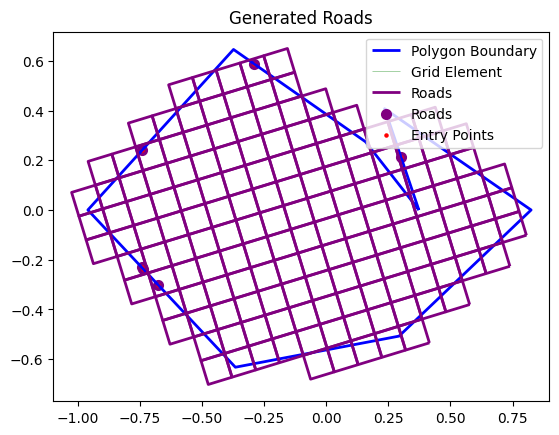

In [95]:
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString, box
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx
from typing import List
def generate_roads(polygon: Polygon, entry_points: List[Point], optimal_grid: List[Polygon]) -> List[LineString]:
    # Create a graph for road construction
    G = nx.Graph()
    
    # Add nodes for entry points
    for entry_point in entry_points:
        G.add_node(entry_point, type='entry_point')
    
    # Add nodes for the exterior boundaries of grid elements inside the polygon
    for grid_element in optimal_grid:
        if polygon.contains(grid_element) or polygon.intersects(grid_element):
            exterior_boundary = grid_element.boundary
            G.add_node(exterior_boundary, type='grid_element_boundary')
    
    # Connect entry points to nearby grid elements
    for entry_point in entry_points:
        for grid_element in optimal_grid:
            if polygon.contains(grid_element):
                if entry_point.distance(grid_element) <= 1.5:  # Adjust this distance threshold as needed
                    exterior_boundary = grid_element.boundary
                    G.add_edge(entry_point, exterior_boundary)
    # Find the shortest paths between entry points
    road_segments = []
    # return G
    entry_point_nodes = [node for node in G.nodes() if G.nodes[node]['type'] == 'entry_point']
    for i in range(len(entry_point_nodes)):
        for j in range(i + 1, len(entry_point_nodes)):
            start_point, path, end_point = nx.shortest_path(G, source=entry_point_nodes[i], target=entry_point_nodes[j])
            # Extract LineString segments from the path
            road_segments.append(path)
    
    return G  # Return a list of LineString objects representing road segments


def visualize_roads(polygon, entry_points, optimal_grid, roads):
    # Create a GeoDataFrame for the roads
    roads_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(roads))
    
    # Create a GeoDataFrame for polygon boundary
    polygon_boundary_gdf = gpd.GeoSeries([polygon.boundary])
    
    # Plot the polygon boundary, entry points, optimal grid, and roads
    fig, ax = plt.subplots()
    polygon_boundary_gdf.plot(ax=ax, color='blue', linewidth=2, label='Polygon Boundary')
    for idx, grid_element in enumerate(optimal_grid):
        if polygon.contains(grid_element) or polygon.intersects(grid_element):
            gpd.GeoSeries([grid_element.boundary]).plot(ax=ax, color='green', 
                                                        linewidth=0.5, 
                                                        label='Grid Element' if idx == 0 else None, 
                                                       alpha=0.5)
    roads_gdf.plot(ax=ax, color='purple', linewidth=2, label='Roads')
    entry_points.plot(ax=ax, marker='o', color='red', markersize=5, label='Entry Points')

    plt.title('Generated Roads')
    plt.legend()
    plt.axis('equal')  # Set equal aspect ratio automatically
    plt.show()

# Example usage:
# Load the GeoJSON file with the CRS information and extract the polygon
file_path = "random_polygon.geojson"
gdf = gpd.read_file(file_path)

# Extract the polygon
polygon = gdf['geometry'].iloc[0]

# Load entry points from a GeoJSON file (entry_points_gdf)
entry_points_gdf = gpd.read_file("entry_points_inside_polygon.geojson")


# Generate roads connecting entry points
roads = generate_roads(polygon, entry_points_gdf.geometry, optimal_grid)

# Visualize the results
visualize_roads(polygon, entry_points_gdf, optimal_grid, 
                roads
               )


In [96]:
line_strings = [elem for elem in roads if type(elem) != Point]

G = nx.Graph()

# Iterate through the list of LineStrings
for line_string in line_strings:
    # Extract the coordinates from the LineString
    coordinates = list(line_string.coords)

    # Add nodes to the graph
    for i, coord in enumerate(coordinates):
        G.add_node(coord, pos=i)  # You can add more attributes as needed

    # Add edges to the graph
    for i in range(len(coordinates) - 1):
        G.add_edge(coordinates[i], coordinates[i + 1])

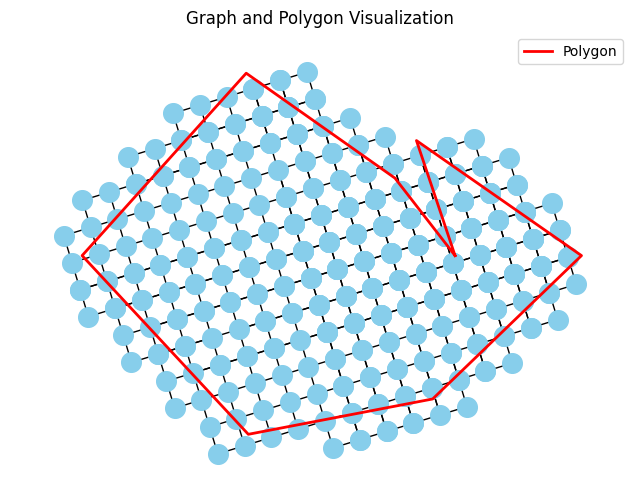

In [97]:
# Visualize the initial graph and the polygon together
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the graph
pos = {node: (node[0], node[1]) for node in G.nodes()}  # Position mapping for nodes
nx.draw(G, pos, node_size=200, node_color='skyblue', ax=ax)

# Plot the polygon
x, y = polygon.exterior.xy
ax.plot(x, y, color='red', linewidth=2, label='Polygon')

plt.title('Graph and Polygon Visualization')
plt.axis('off')  # Turn off axis labels and ticks
plt.legend()
plt.show()

/var/folders/l1/b01fb2tx5l12nfvrxfmqxggh0000gn/T/ipykernel_89363/3601225500.py:62: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


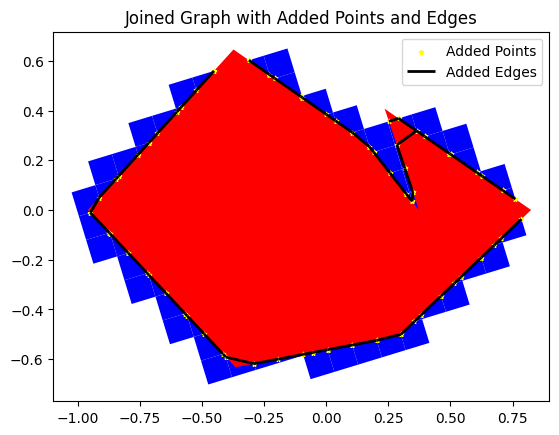

In [208]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, MultiLineString
import pandas as pd

def join_polygon_and_grid(polygon, optimal_grid):
    # Initialize variables to store added points and edges
    added_points = []
    added_edges = []
    
    # Create a copy of the polygon boundary as LineString
    polygon_boundary = polygon.boundary
    
    # Create a graph to store the joined elements
    joined_graph = gpd.GeoSeries()
    
    # Iterate through each grid element
    for grid_element in optimal_grid:
        # Check if the polygon boundary intersects the grid element
        if polygon.boundary.intersects(grid_element):
            # Get the intersection points as a list of Shapely Point objects
            intersection_points = polygon_boundary.intersection(grid_element.boundary)
            
            # Iterate through the intersection points
            for point in intersection_points.geoms:
                if point not in joined_graph:

                    # Add the intersection point to the joined graph
                    joined_graph = pd.concat([joined_graph, gpd.GeoSeries(point)])
                    added_points.append(point)
            
            # Add edges connecting the intersection points
            for i in range(len(intersection_points.geoms) - 1):
                edge = LineString([intersection_points.geoms[i], intersection_points.geoms[i+1]])
                if edge not in joined_graph:
                    joined_graph = pd.concat([joined_graph, gpd.GeoSeries(edge)])
                    added_edges.append(edge)
    
    return joined_graph, added_points, added_edges

def visualize_results(polygon, optimal_grid, added_points, added_edges):
    # Create a GeoDataFrame for the initial grid and polygon
    initial_grid_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(optimal_grid))
    polygon_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries([polygon]))
    
    # Create a GeoDataFrame for the added points and edges
    added_points_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(added_points))
    added_edges_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(added_edges))
    
    # Plot the initial grid and polygon
    fig, ax = plt.subplots()
    initial_grid_gdf.plot(ax=ax, color='blue', label='Initial Grid')
    polygon_gdf.plot(ax=ax, color='red', label='Polygon')
    
    # Plot the added points as stars
    added_points_gdf.plot(ax=ax, marker='*', color='yellow', markersize=10, label='Added Points')
    
    # Plot the added edges in black
    added_edges_gdf.plot(ax=ax, color='black', linewidth=2, label='Added Edges')
    
    plt.title('Joined Graph with Added Points and Edges')
    plt.legend()
    plt.axis('equal')
    plt.show()

# Usage
joined_graph, added_points, added_edges = join_polygon_and_grid(polygon, optimal_grid)
visualize_results(polygon, optimal_grid, added_points, added_edges)


/var/folders/l1/b01fb2tx5l12nfvrxfmqxggh0000gn/T/ipykernel_89363/2970341484.py:62: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


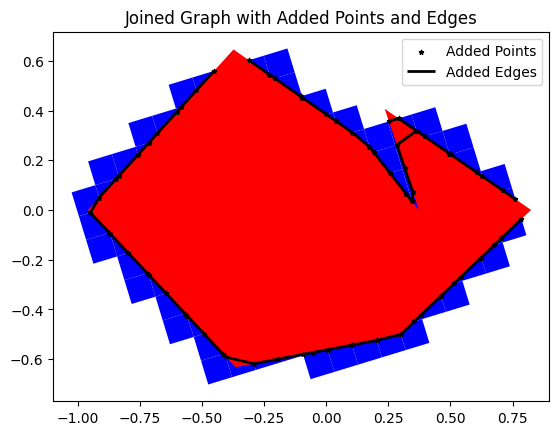

/Users/dmitrijrudenko/Library/Caches/pypoetry/virtualenvs/samolet-b4IPLwFX-py3.11/lib/python3.11/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/dmitrijrudenko/Library/Caches/pypoetry/virtualenvs/samolet-b4IPLwFX-py3.11/lib/python3.11/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/var/folders/l1/b01fb2tx5l12nfvrxfmqxggh0000gn/T/ipykernel_89363/2970341484.py:62: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


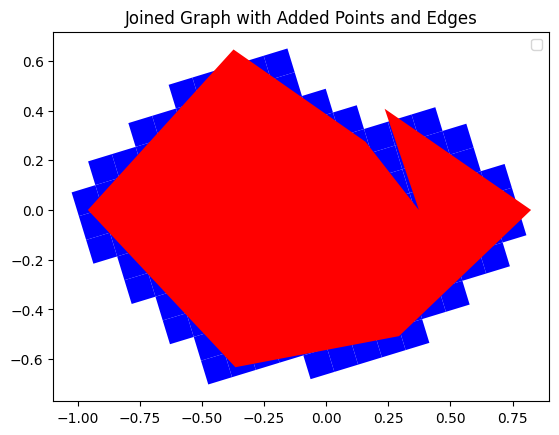

In [206]:
def trim_joined_graph(polygon, joined_graph):
    # Create a copy of the polygon boundary as LineString
    polygon_boundary = polygon.boundary

    # Initialize lists to store the filtered points and edges
    filtered_points = []
    filtered_edges = []

    # Iterate through each element in the joined_graph
    for element in joined_graph:
        if isinstance(element, Point):
            # Check if the point is within the polygon boundary
            if polygon_boundary.contains(element):
                filtered_points.append(element)
        elif isinstance(element, LineString):
            # Check if the line intersects the polygon boundary
            if polygon_boundary.intersects(element):
                # Clip the line to the polygon boundary
                intersection = polygon_boundary.intersection(element)
                if isinstance(intersection, LineString):
                    filtered_edges.append(intersection)
                elif isinstance(intersection, MultiLineString):
                    # If intersection results in multiple lines, add them individually
                    for line in intersection:
                        filtered_edges.append(line)

    # Combine the filtered points and edges into a new GeoSeries
    filtered_graph = gpd.GeoSeries(filtered_points + filtered_edges)

    return filtered_graph

# Usage in your pipeline
joined_graph, added_points, added_edges = join_polygon_and_grid(polygon, optimal_grid)
filtered_graph = trim_joined_graph(polygon, joined_graph)
visualize_results(polygon, optimal_grid, added_points, added_edges)
visualize_results(polygon, optimal_grid, [], filtered_graph)


In [207]:
import networkx as nx

def join_polygon_and_grid_graph(polygon, G):
    # Initialize variables to store added points and edges
    added_points = []
    added_edges = []
    
    # Create a copy of the polygon boundary as LineString
    polygon_boundary = polygon.boundary
    
    # Create a graph to store the joined elements
    joined_graph = gpd.GeoSeries()
    
    # Iterate through each edge in the graph G
    for edge in G.edges():
        line_string = LineString(edge)
        
        # Check if the polygon boundary intersects the edge
        if polygon_boundary.intersects(line_string):
            # Get the intersection points as a list of Shapely Point objects
            intersection_points = polygon_boundary.intersection(line_string)
            
            # Iterate through the intersection points
            for point in intersection_points.geoms:
                if point not in joined_graph:
                    # Add the intersection point to the joined graph
                    joined_graph = pd.concat([joined_graph, gpd.GeoSeries(point)])
                    added_points.append(point)
            
            # Add edges connecting the intersection points
            for i in range(len(intersection_points.geoms) - 1):
                edge = LineString([intersection_points.geoms[i], intersection_points.geoms[i+1]])
                if edge not in joined_graph:
                    joined_graph = pd.concat([joined_graph, gpd.GeoSeries(edge)])
                    added_edges.append(edge)
    
    return joined_graph, added_points, added_edges

joined_graph, added_points, added_edges = join_polygon_and_grid_graph(polygon, G)
visualize_results(polygon, [], added_points, added_edges)
visualize_results(polygon, [], [], joined_graph)


AttributeError: 'Point' object has no attribute 'geoms'

In [181]:
import shapely
intersecting_elems = []
for grid_element in optimal_grid:
        # Check if the polygon boundary intersects the grid element
        if polygon.boundary.intersects(grid_element):
            # Get the intersection points as a list of Shapely Point objects
            intersection_points = polygon.boundary.intersection(grid_element.boundary)
            
            # Iterate through the intersection points
            for point in intersection_points.geoms:
                if point not in joined_graph:
                    # Add the intersection point to the joined graph
                    joined_graph = joined_graph.append(gpd.GeoSeries(point), ignore_index=True)
                    added_points.append(point)

AttributeError: 'Graph' object has no attribute 'append'

In [176]:
str(intersection_points)

'MULTIPOINT (-0.8727464466789132 -0.0920777250736884, -0.8690149650397404 -0.0960553140943574)'

In [180]:
list(intersection_points.geoms)

[<POINT (-0.873 -0.092)>, <POINT (-0.869 -0.096)>]

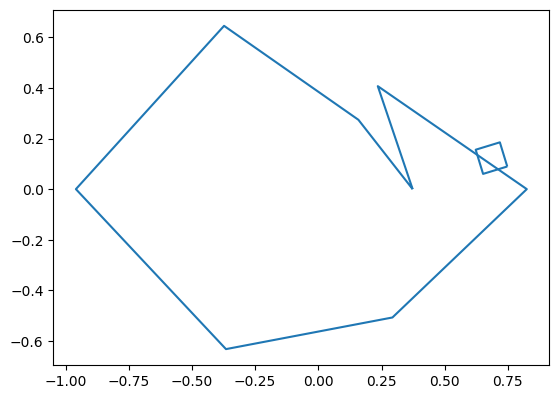

In [168]:
p = gpd.GeoSeries([grid_element.boundary, polygon.boundary])
p.plot()
plt.show()

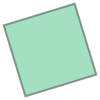

In [163]:
intersecting_elems

[<LINESTRING (-0.873 -0.092, -0.869 -0.096)>,
 <LINESTRING (-0.949 -0.011, -0.873 -0.092)>,
 <LINESTRING (-0.914 0.05, -0.959 0, -0.949 -0.011)>,
 <LINESTRING (-0.72 -0.255, -0.714 -0.261)>,
 <LINESTRING (-0.797 -0.173, -0.72 -0.255)>,
 <LINESTRING (-0.869 -0.096, -0.797 -0.173)>,
 <LINESTRING (-0.845 0.125, -0.914 0.05)>,
 <LINESTRING (-0.835 0.136, -0.845 0.125)>,
 <LINESTRING (-0.568 -0.417, -0.559 -0.427)>,
 <LINESTRING (-0.644 -0.336, -0.568 -0.417)>,
 <LINESTRING (-0.714 -0.261, -0.644 -0.336)>,
 <LINESTRING (-0.757 0.222, -0.835 0.136)>,
 <LINESTRING (-0.415 -0.58, -0.404 -0.592)>,
 <LINESTRING (-0.492 -0.498, -0.415 -0.58)>,
 <LINESTRING (-0.559 -0.427, -0.492 -0.498)>,
 <LINESTRING (-0.714 0.27, -0.757 0.222)>,
 <LINESTRING (-0.679 0.309, -0.714 0.27)>,
 <LINESTRING (-0.404 -0.592, -0.365 -0.633, -0.291 -0.619)>,
 <LINESTRING (-0.601 0.395, -0.679 0.309)>,
 <LINESTRING (-0.291 -0.619, -0.192 -0.6)>,
 <LINESTRING (-0.583 0.415, -0.601 0.395)>,
 <LINESTRING (-0.523 0.481, -0.583

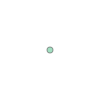

In [159]:
from shapely import box, LineString, normalize, Polygon, intersection

line = LineString([(0, 0), (1, 1)])
line2 = LineString([(0, 1), (1, 0)])
line.intersection(line2)

In [ ]:
box1 = box(0, 0, 2, 2)

box2 = box(1, 1, 3, 3)

normalize(intersection(box1, box2))
<POLYGON ((1 1, 1 2, 2 2, 2 1, 1 1))>

box1 = box(0.1, 0.2, 2.1, 2.1)

intersection(box1, box2, grid_size=1)
<POLYGON ((2 2, 2 1, 1 1, 1 2, 2 2))>